In [ ]:

import qiskit; import numpy as np; import matplotlib.pyplot as plt; import random

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import Aer, execute
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap

from qiskit import qpy

from qoop.evolution.environment_synthesis import MetadataSynthesis
from qoop.evolution.generator import by_num_rotations,by_num_rotations_and_cnot
from qoop.evolution.environment import EEnvironment
from qoop.evolution.crossover import onepoint
from qoop.evolution.mutate import bitflip_mutate
from qoop.evolution.divider import by_num_cnot
from qoop.evolution.threshold import synthesis_threshold
from qoop.backend.constant import operations
from qoop.evolution.normalizer import by_num_cnot as normalizer_by_num_cnot
from qoop.evolution import divider
from qoop.backend.utilities import load_circuit



# Test each component

In [62]:
def generate_data(n_samples,n_features,centers, random_state):
    X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, random_state=random_state)
    y = 2 * y - 1  # Convert labels to {-1, +1} for compatibility with QSVC
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

X_train,X_test,y_train, y_test = generate_data(n_samples=120, n_features=4, centers=2, random_state=41)
feature_dimension = 2
FeatureM = ZZFeatureMap(feature_dimension=2, reps=1)

def Define_Eval_QSVM(feature_dimension):
    # Step 2:

    #FeatureM = ZZFeatureMap(feature_dimension=feature_dimension, reps=num_rep)
    # Step 3: Use QuantumKernel to compute the kernel matrix
    qasm = Aer.get_backend('qasm_simulator')
    quantum_kernel = QuantumKernel(feature_map=feature_dimension,quantum_instance=qasm) # Encode each data point into each separated state (500 data points -> 500 states) 
    #and create K(xi,xj) = [state ij;...], is computing each state with each other, 500 states -> K matrix (500x500)

    # Step 4: Train a QSVM
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(X_train, y_train) #fit(df_train[features], df_train['Species'])

    # Step 5: Evaluate the QSVM
    accuracy = qsvc.score(X_test, y_test)
    return accuracy


def load_circuits(fitness_levels):
    circuits = []
    for fitness in range(1, fitness_levels+1):
        print(fitness)
        file_name = f'4qubits_FM{fitness}_fitness_2024-12-12/best_circuit.qpy'
        with open(file_name, 'rb') as fd:
            circuit = qpy.load(fd)[0]
            print(circuit)  # Print if needed
            circuits.append(circuit)
    return circuits

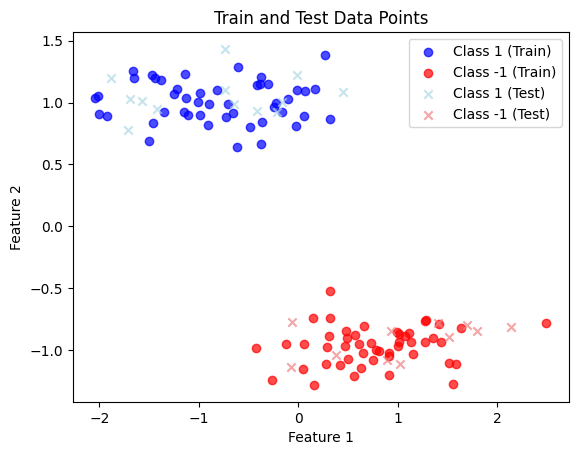

In [49]:
plt.figure()  # Create a new figure
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', label='Class 1 (Train)', alpha=0.7)
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], color='red', label='Class -1 (Train)', alpha=0.7)
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='lightblue', label='Class 1 (Test)', marker='x', alpha=0.7)
plt.scatter(X_test[y_test == -1, 0], X_test[y_test == -1, 1], color='lightcoral', label='Class -1 (Test)', marker='x', alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Train and Test Data Points')
plt.legend()

8


d:\Anaconda-Env\GAqiskit\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


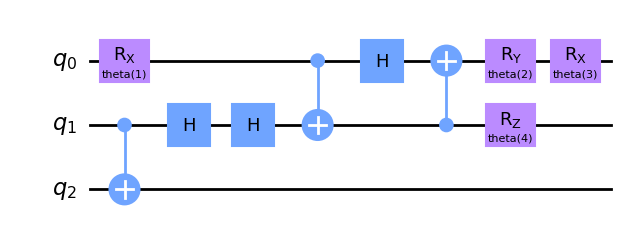

In [39]:
env_metadata = MetadataSynthesis(
    num_qubits=3,
    num_cnot=3,
    num_rx=2,
    num_ry=1,
    num_rz=1,
    depth=5,
    num_circuit=4,
    num_generation=10,
    prob_mutate=0.01
)

qc = by_num_rotations_and_cnot(env_metadata)
print(qc.depth())
qc.draw('mpl')

In [43]:
# Define the metadata
env_metadata = MetadataSynthesis(
    num_qubits=4,            # Number of qubits
    num_cnot=3,              # Number of CNOT gates
    num_rx=2,                # Number of RX gates
    num_ry=1,                # Number of RY gates
    num_rz=1,                # Number of RZ gates
    depth=5,                 # Depth of the circuit
    num_circuit=4,           # Number of circuits in the population
    num_generation=10,       # Number of generations
    prob_mutate=0.01         # Mutation probability
)

# Define the environment
env = EEnvironment(
    metadata=env_metadata,
    fitness_func=Define_Eval_QSVM,
    generator_func=by_num_rotations_and_cnot,  # Use the new generator function
    crossover_func=onepoint(
        divider.by_num_cnot(int(env_metadata.num_cnot / 2)),
        normalizer_by_num_cnot(env_metadata.num_cnot)
    ),
    mutate_func=bitflip_mutate(operations),
    threshold_func=synthesis_threshold
)

# Run the evolution process
env.evol(mode="noparallel")

Initialize list of circuit ...
Start evol progress ...
Running at generation 1
[0.9583 1.     0.7083 1.    ]
Saving circuit ...
End progress soon at generation 1, best score ever: 1.0


In [44]:
circuit1=load_circuit('4qubits_Define_Eval_QSVM_2024-12-12/best_circuit')
circuit1.draw(style="mql")

┌───┐
q_0: ────────────────────────────────────────────■────────┤ X ├
     ┌──────────────┐┌──────────────┐┌───┐     ┌─┴─┐      └─┬─┘
q_1: ┤ Rx(theta(1)) ├┤ Ry(theta(2)) ├┤ X ├─────┤ X ├────────┼──
     ├──────────────┤└──────────────┘└─┬─┘     └───┘        │  
q_2: ┤ Rx(theta(4)) ├──────────────────┼────────────────────┼──
     └────┬───┬─────┘                  │  ┌──────────────┐  │  
q_3: ─────┤ H ├────────────────────────■──┤ Rz(theta(3)) ├──■──
          └───┘                           └──────────────┘

In [45]:
clf = SVC( gamma=0.877551020408163, kernel="rbf").fit(X_train, y_train)
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

# Print classification report
print("Training Classification Report:")
print(classification_report(y_train, train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, test_pred))

Training Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        51

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96


Testing Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         9

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [47]:
qasm = Aer.get_backend('qasm_simulator')
quantum_kernel = QuantumKernel(feature_map=circuit1,quantum_instance=qasm) # Encode each data point into each separated state (500 data points -> 500 states) 
#and create K(xi,xj) = [state ij;...], is computing each state with each other, 500 states -> K matrix (500x500)

# Step 4: Train a QSVM
qsvc = QSVC(quantum_kernel=quantum_kernel)
qsvc.fit(X_train, y_train) #fit(df_train[features], df_train['Species'])

# Step 5: Evaluate the QSVM
accuracy = qsvc.score(X_test, y_test)
test_pred1=qsvc.predict(X_test)
print(classification_report(y_test, test_pred1))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         9

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



# Setup for big Component

start with 4 number features
done ZZ/Z Feature Map
Running GA
Initialize list of circuit ...
Start evol progress ...
Running at generation 1
[1.     1.     0.9583 0.9583]
Saving circuit ...
End progress soon at generation 1, best score ever: 1.0
Done GA
Complete collect data at 4 features
start with 5 number features
done ZZ/Z Feature Map
Running GA
Initialize list of circuit ...
Start evol progress ...
Running at generation 1
[1.     0.9583 1.     0.4583]
Saving circuit ...
End progress soon at generation 1, best score ever: 1.0
Done GA
Complete collect data at 5 features
start with 6 number features
done ZZ/Z Feature Map
Running GA
Initialize list of circuit ...
Start evol progress ...
Running at generation 1
[1.     0.9583 1.     1.    ]
Saving circuit ...
End progress soon at generation 1, best score ever: 1.0
Done GA
Complete collect data at 6 features
start with 7 number features
done ZZ/Z Feature Map
Running GA
Initialize list of circuit ...
Start evol progress ...
Running at ge

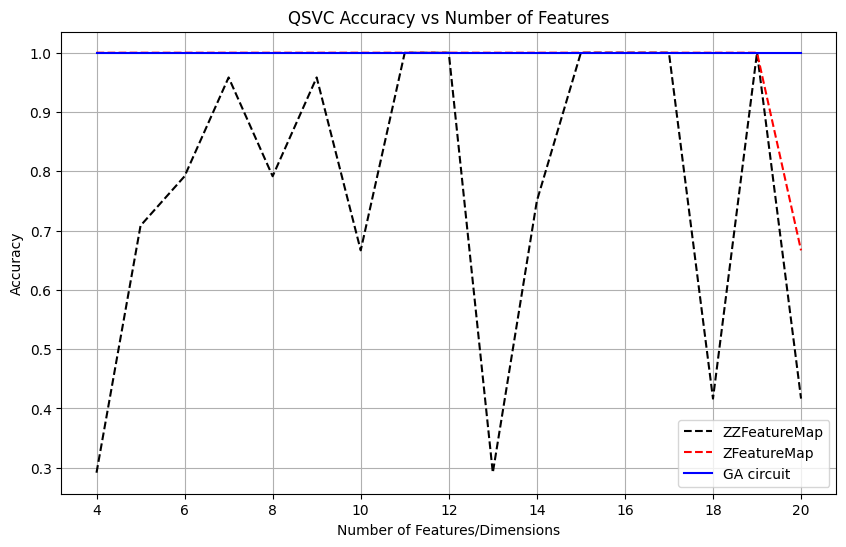

In [69]:
def setup_environment(num_qubits):
    """
    Sets up the environment with dynamically assigned parameters.

    Args:
        num_qubits (int): The number of qubits to use.

    Returns:
        file.qpy: The circuit configured.
    """
    num_cnot = num_qubits + 1

    num_rx = random.randint(0, num_qubits)
    num_ry = random.randint(0, num_qubits - num_rx)
    num_rz = num_qubits - (num_rx + num_ry)  # Ensure the sum matches num_qubits

    # Define the metadata
    env_metadata = MetadataSynthesis(
        num_qubits=num_qubits,
        num_cnot=num_cnot,
        num_rx=num_rx,
        num_ry=num_ry,
        num_rz=num_rz,
        depth=5,  # Depth of the circuit
        num_circuit=4,  # Number of circuits in the population
        num_generation=10,  # Number of generations
        prob_mutate=0.01  # Mutation probability
    )

    # Define the environment
    env = EEnvironment(
        metadata=env_metadata,
        fitness_func=Define_Eval_QSVM,
        generator_func=by_num_rotations_and_cnot,  # Use the new generator function
        crossover_func=onepoint(
            by_num_cnot(int(env_metadata.num_cnot / 2)),
            normalizer_by_num_cnot(env_metadata.num_cnot)
        ),
        mutate_func=bitflip_mutate(operations),
        threshold_func=synthesis_threshold
    ).evol(mode="noparallel")

    return
# Generate data
def generate_data(n_samples, n_features, centers, random_state):
    X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, random_state=random_state)
    y = 2 * y - 1  # Convert labels to {-1, +1} for compatibility with QSVC
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

# Define evaluation function for QSVM
def Define_Eval_QSVM(feature_map):
    qasm = Aer.get_backend('statevector_simulator')
    quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=qasm)
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(X_train, y_train)
    accuracy = qsvc.score(X_test, y_test)
    return accuracy

# Load GA circuits from .qpy files
def load_circuits(fitness_levels):
    circuits = []
    for fitness in range(4, fitness_levels + 1):
        file_name = f'{fitness}qubits_Define_Eval_QSVM_2024-12-12/best_circuit'
        with open(file_name, 'rb') as fd:
            circuit = qpy.load(fd)[0]
            circuits.append(circuit)
    return circuits

# Parameters
num_features_list = range(4, 21, 1)  # Number of features from 2 to 20
accuracies = {
    "ZZFeatureMap": [],
    "ZFeatureMap": [],
    "GA_circuit": []
}

# Generate initial dataset
X_train, X_test, y_train, y_test = generate_data(n_samples=120, n_features=4, centers=2, random_state=0)

# Run evaluations
for num_features in num_features_list:
    print(f'start with {num_features} number features')
    # Update data for the current number of features
    X_train, X_test, y_train, y_test = generate_data(n_samples=120, n_features=num_features, centers=2, random_state=0)

    # QSVC with ZZFeatureMap
    zz_feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    accuracy_zz = Define_Eval_QSVM(zz_feature_map)
    accuracies["ZZFeatureMap"].append(accuracy_zz)

    # QSVC with ZFeatureMap
    z_feature_map = ZFeatureMap(feature_dimension=num_features, reps=1)
    accuracy_z = Define_Eval_QSVM(z_feature_map)
    accuracies["ZFeatureMap"].append(accuracy_z)
    print("done ZZ/Z Feature Map")

    # QSVC with GA circuit
    print("Running GA")
    setup_environment(num_features)
    print("Done GA")
    
    
    file_name = f'{num_features}qubits_Define_Eval_QSVM_2024-12-12/best_circuit.qpy'
    with open(file_name, 'rb') as fd:
        circuit = qpy.load(fd)[0]
    
    accuracy_ga = Define_Eval_QSVM(circuit)
    accuracies["GA_circuit"].append(accuracy_ga)
    print(f"Complete collect data at {num_features} features")
    

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, accuracies["ZZFeatureMap"], 'k--', label="ZZFeatureMap")
plt.plot(num_features_list, accuracies["ZFeatureMap"], 'r--', label="ZFeatureMap")
plt.plot(num_features_list, accuracies["GA_circuit"], 'b-', label="GA circuit")
plt.xlabel("Number of Features/Dimensions")
plt.ylabel("Accuracy")
plt.legend()
plt.title("QSVC Accuracy vs Number of Features")
plt.grid()
plt.show()